In [ ]:
from Read_Files import read_excel_dataframe
import pandas as pd

df = read_excel_dataframe("chart_result_19.xlsx")

In [2]:
# Keep only the requested columns and normalize basic dtypes
focus_cols = [
    "Part Number", "Condition Code", "Quantity", "Availability of Part", "Opportunity",
    "IS_OEM", "IS_OPERATOR", "IS_MRO", "IS_BROKER",
    "Month_Bucket", "Quarter_Bucket", "Received At (UTC)",
    "customer_Conv Rate", "customer_Total CQ Count", "customer_NQ Count", "customer_CQ Count Sold",
]

missing_cols = [c for c in focus_cols if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns: {missing_cols}")

df_focus = df[focus_cols].copy()

# Parse timestamp
df_focus["Received At (UTC)"] = pd.to_datetime(df_focus["Received At (UTC)"], errors="coerce", utc=True)

# Ensure integer-like columns are integer dtype where possible
int_cols = [
    "Quantity", "customer_Total CQ Count", "customer_CQ Count Sold",
    "IS_OEM", "IS_OPERATOR", "IS_MRO", "IS_BROKER",
]
for c in int_cols:
    if df_focus[c].isna().any():
        df_focus[c] = pd.to_numeric(df_focus[c], errors="coerce").astype("Int64")
    else:
        df_focus[c] = pd.to_numeric(df_focus[c], errors="coerce").astype(int)

# Preview
df_focus.head()

,Part Number,Condition Code,Quantity,Availability of Part,Opportunity,IS_OEM,IS_OPERATOR,IS_MRO,IS_BROKER,Month_Bucket,Quarter_Bucket,Received At (UTC),customer_Conv Rate,customer_Total CQ Count,customer_NQ Count,customer_CQ Count Sold
0,4505476,OH,1,1.0,Processed,0,0,0,1,2024-10,2024Q4,2024-10-14 15:54:00+00:00,0.117949,249,54.0,23
1,340-051-901-0,OH,1,1.0,Not Read w/Stock,0,0,0,0,2024-09,2024Q3,2024-09-06 10:59:00+00:00,0.124294,1227,342.0,110
2,60-755100-5,SV,1,0.0,No Stock,0,0,0,1,2024-09,2024Q3,2024-09-24 22:20:00+00:00,0.117949,249,54.0,23
3,106-1-1100-03,SV,1,1.0,Not Read w/Stock,0,0,0,1,2024-12,2024Q4,2024-12-13 16:14:00+00:00,0.181818,32,10.0,4
4,4082260-937,SV,1,1.0,Not Read w/Stock,0,0,0,0,2024-09,2024Q3,2024-09-24 16:37:00+00:00,0.124294,1227,342.0,110


In [3]:
df = df_focus
 

In [4]:
# Correlation matrix for numeric/boolean columns in df
numeric_df = df.select_dtypes(include=['number', 'bool']).copy()

# Cast booleans to integers so they contribute to correlations
bool_cols = numeric_df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    numeric_df[bool_cols] = numeric_df[bool_cols].astype(int)

corr_matrix = numeric_df.corr(method='pearson')

# Display a styled correlation matrix
corr_matrix.style.background_gradient(cmap='RdBu_r', vmin=-1, vmax=1).format("{:.2f}")

,Quantity,Availability of Part,IS_OEM,IS_OPERATOR,IS_MRO,IS_BROKER,customer_Conv Rate,customer_Total CQ Count,customer_NQ Count,customer_CQ Count Sold
Quantity,1.00,0.11,-0.00,0.00,-0.01,0.02,0.00,0.00,0.00,0.00
Availability of Part,0.11,1.00,0.00,-0.00,0.00,0.01,0.04,-0.00,-0.00,-0.00
IS_OEM,-0.00,0.00,1.00,-0.01,0.07,-0.08,0.04,-0.00,-0.00,-0.00
IS_OPERATOR,0.00,-0.00,-0.01,1.00,-0.03,-0.11,0.06,-0.01,-0.00,0.00
IS_MRO,-0.01,0.00,0.07,-0.03,1.00,-0.17,-0.03,0.00,0.01,0.01
IS_BROKER,0.02,0.01,-0.08,-0.11,-0.17,1.00,-0.12,-0.03,-0.03,-0.06
customer_Conv Rate,0.00,0.04,0.04,0.06,-0.03,-0.12,1.00,-0.02,-0.02,0.02
customer_Total CQ Count,0.00,-0.00,-0.00,-0.01,0.00,-0.03,-0.02,1.00,1.00,0.99
customer_NQ Count,0.00,-0.00,-0.00,-0.00,0.01,-0.03,-0.02,1.00,1.00,0.99
customer_CQ Count Sold,0.00,-0.00,-0.00,0.00,0.01,-0.06,0.02,0.99,0.99,1.00


# XGBoost model for intermittent demand (Quantity)


This section builds a feature set aggregated monthly per part, fits an XGBoost model with a Tweedie objective (robust to many zeros), evaluates with a time-based split, and provides a helper to forecast the next month per part.

In [5]:
# Aggregate to monthly per part and build features suitable for intermittent demand
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Prepare monthly aggregation per part
work = df.copy()
work['Month_Bucket'] = pd.to_datetime(work['Month_Bucket'], errors='coerce')
work = work.dropna(subset=['Part Number','Month_Bucket'])

# If Quantity is not numeric Int64, coerce to numeric
work['Quantity'] = pd.to_numeric(work['Quantity'], errors='coerce').fillna(0)

# Check availability of optional columns
has_opp = 'Opportunity' in work.columns
has_avail = 'Availability of Part' in work.columns
opt_cols = {
    'IS_OEM': 'is_oem',
    'IS_OPERATOR': 'is_operator',
    'IS_MRO': 'is_mro',
    'IS_BROKER': 'is_broker',
    'customer_Conv Rate': 'conv_rate',
    'customer_Total CQ Count': 'cq_total',
    'customer_NQ Count': 'nq_count',
    'customer_CQ Count Sold': 'cq_sold',
}

# Build dynamic named aggregations
named_agg = {
    'qty': ('Quantity','sum'),
    'rfq_count': ('Quantity','size'),
}
if has_opp:
    named_agg['opp'] = ('Opportunity','sum')
if has_avail:
    named_agg['avail_mode'] = ('Availability of Part', lambda s: s.astype(str).str.strip().str.title().value_counts().idxmax() if len(s)>0 else 'Unknown')
for src, dest in opt_cols.items():
    if src in work.columns:
        func = 'max' if src in ['IS_OEM','IS_OPERATOR','IS_MRO','IS_BROKER'] else 'mean'
        named_agg[dest] = (src, func)

# Perform aggregation
agg = work.groupby(['Part Number','Month_Bucket']).agg(**named_agg).reset_index()

# If availability column missing, create a default category
if 'avail_mode' not in agg.columns:
    agg['avail_mode'] = 'Unknown'

# Add date features
agg['year'] = agg['Month_Bucket'].dt.year
agg['month'] = agg['Month_Bucket'].dt.month
agg['quarter'] = agg['Month_Bucket'].dt.quarter

# Target and features
target_col = 'qty'
cat_cols = ['Part Number','avail_mode']
candidate_num_cols = ['opp','rfq_count','is_oem','is_operator','is_mro','is_broker','conv_rate','cq_total','nq_count','cq_sold','year','month','quarter']
num_cols = [c for c in candidate_num_cols if c in agg.columns]

# Ensure numeric columns are true numeric floats (avoid pandas extension dtypes in sparse concat)
if len(num_cols) > 0:
    for c in num_cols:
        agg[c] = pd.to_numeric(agg[c], errors='coerce')
    agg[num_cols] = agg[num_cols].fillna(0.0).astype(float)

# Fixed split cutoffs (requested)
train_cutoff = (pd.Timestamp('2025-05-01') + pd.offsets.MonthEnd(0))
valid_cutoff = (pd.Timestamp('2025-07-01') + pd.offsets.MonthEnd(0))
train_idx = agg['Month_Bucket'] <= train_cutoff
valid_idx = (agg['Month_Bucket'] > train_cutoff) & (agg['Month_Bucket'] <= valid_cutoff)
train_df = agg.loc[train_idx].copy()
valid_df = agg.loc[valid_idx].copy()
if len(train_df) == 0 or len(valid_df) == 0:
    raise RuntimeError('Not enough data for fixed time-based split. Ensure data covers up to 2025-07.')

# Preprocess: one-hot encode categorical (dense), pass through numeric as-available
the_ohe = OneHotEncoder(handle_unknown='ignore', min_frequency=10, sparse_output=False)
transformers = [
    ('cat', the_ohe, cat_cols)
]
if len(num_cols) > 0:
    transformers.append(('num', 'passthrough', num_cols))
pre = ColumnTransformer(transformers)

# XGBoost with Tweedie objective (handles zero-inflated, continuous positive targets)
xgb = XGBRegressor(
    objective='reg:tweedie',
    tweedie_variance_power=1.2,  # 1<p<=2 suitable for zero-inflated
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    tree_method='hist'
)
pipe = Pipeline([
    ('pre', pre),
    ('model', xgb)
])

# Fit on training set
pipe.fit(train_df[cat_cols + num_cols], train_df[target_col])

# Evaluate on validation
pred_valid = pipe.predict(valid_df[cat_cols + num_cols])
mse = mean_squared_error(valid_df[target_col], pred_valid)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(valid_df[target_col], pred_valid)
print({'RMSE': rmse, 'MAE': mae, 'n_valid': len(valid_df), 'features': {'cat': cat_cols, 'num': num_cols}, 'cutoffs': {'train': str(train_cutoff.date()), 'valid': str(valid_cutoff.date())}})

# Keep artifacts for later use
model_pipe = pipe
features_spec = {'cat_cols': cat_cols, 'num_cols': num_cols, 'target_col': target_col}


{'RMSE': 33.41558130900538, 'MAE': 3.965649127960205, 'n_valid': 4331, 'features': {'cat': ['Part Number', 'avail_mode'], 'num': ['opp', 'rfq_count', 'is_oem', 'is_operator', 'is_mro', 'is_broker', 'conv_rate', 'cq_total', 'nq_count', 'cq_sold', 'year', 'month', 'quarter']}, 'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}}


In [6]:
# Helper to predict next-month quantity for a specific part

def predict_next_month_quantity(part_number, reference_month=None):
    """Predict next month's demand for a given part.

    - reference_month: pd.Timestamp or 'YYYY-MM' string; if None uses max Month_Bucket in data
    """
    if reference_month is None:
        ref = agg['Month_Bucket'].max()
    else:
        ref = pd.to_datetime(reference_month)
    next_month = (ref + pd.offsets.MonthBegin(1)).normalize()

    # Build one row using most recent known info for the part
    part_mask = agg['Part Number'].astype(str).str.upper()==str(part_number).upper()
    last_row_df = agg.loc[part_mask].sort_values('Month_Bucket').tail(1)
    if last_row_df.empty:
        raise ValueError(f'No history found for part {part_number}')

    last_row = last_row_df.iloc[0]

    # Build feature row dynamically using features_spec
    X = {}
    # categorical features
    for c in features_spec['cat_cols']:
        if c == 'Part Number':
            X[c] = last_row['Part Number']
        elif c == 'avail_mode':
            X[c] = last_row['avail_mode'] if 'avail_mode' in last_row else 'Unknown'
        else:
            X[c] = last_row[c] if c in last_row.index else None

    # numeric features
    for c in features_spec['num_cols']:
        if c in ['year','month','quarter']:
            # advance to next month calendar features
            if c == 'year':
                X[c] = next_month.year
            elif c == 'month':
                X[c] = next_month.month
            elif c == 'quarter':
                X[c] = pd.Timestamp(next_month).quarter
        else:
            # pull from last row if available, else fallback
            X[c] = last_row[c] if c in last_row.index else 0

    X_df = pd.DataFrame([X])
    pred = model_pipe.predict(X_df[features_spec['cat_cols'] + features_spec['num_cols']])[0]
    return max(0.0, float(pred))

# Example prediction
# predict_next_month_quantity('442653')

In [7]:
predict_next_month_quantity('442653')

8.147639274597168

In [8]:
# Report validation MAE and RMSE with fixed cutoffs
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import mean_squared_error, mean_absolute_error
if 'model_pipe' not in globals() or 'features_spec' not in globals():
    raise RuntimeError("Please run the training cell first to create model_pipe and features_spec.")
cat_cols = features_spec['cat_cols']
num_cols = features_spec['num_cols']
target_col = features_spec.get('target_col', 'qty')
# Use the same fixed cutoffs
train_cutoff = (pd.Timestamp('2025-05-01') + pd.offsets.MonthEnd(0))
valid_cutoff = (pd.Timestamp('2025-07-01') + pd.offsets.MonthEnd(0))
if 'agg' not in globals():
    raise RuntimeError("Validation data not found. Run the training cell to build 'agg'.")
valid_df = agg.loc[(agg['Month_Bucket'] > train_cutoff) & (agg['Month_Bucket'] <= valid_cutoff)].copy()
# Safety: numeric dtypes for model input
for c in num_cols:
    valid_df[c] = pd.to_numeric(valid_df[c], errors='coerce')
if len(num_cols) > 0:
    valid_df[num_cols] = valid_df[num_cols].fillna(0.0).astype(float)
# Predict and score
X_valid = valid_df[cat_cols + num_cols]
y_true = valid_df[target_col].to_numpy()
y_pred = model_pipe.predict(X_valid)
mae = float(mean_absolute_error(y_true, y_pred))
rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
print(f"Train cutoff: {train_cutoff.date()} | Validation cutoff: {valid_cutoff.date()}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
display(pd.DataFrame({"MAE": [mae], "RMSE": [rmse], "n_valid": [len(valid_df)], "train_cutoff": [str(train_cutoff.date())], "valid_cutoff": [str(valid_cutoff.date())]}))


Train cutoff: 2025-05-31 | Validation cutoff: 2025-07-31
MAE: 3.966
RMSE: 33.416


,MAE,RMSE,n_valid,train_cutoff,valid_cutoff
0,3.965649,33.415581,4331,2025-05-31,2025-07-31


In [9]:
# Plot a single part's training/validation history and next-month forecast with fixed cutoffs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_part_history_and_forecast(part_number, show_metrics=True):
    """Plot monthly actuals vs model predictions for a part across train/validation and a one-step-ahead forecast.
    Uses fixed split cutoffs: train <= 2025-05, validation (2025-06 to 2025-07 inclusive).
    Requires training cell to have produced: agg, model_pipe, features_spec.
    """
    # Guards
    missing = [n for n in ['agg','model_pipe','features_spec'] if n not in globals()]
    if missing:
        raise RuntimeError(f"Missing required objects from training cell: {missing}")
    cat_cols = features_spec['cat_cols']
    num_cols = features_spec['num_cols']
    target_col = features_spec.get('target_col','qty')

    # Data for this part
    part_mask = agg['Part Number'].astype(str).str.upper()==str(part_number).upper()
    part_df = agg.loc[part_mask].sort_values('Month_Bucket').copy()
    if part_df.empty:
        raise ValueError(f"No monthly history found for part {part_number}")

    # Fixed cutoffs
    train_cutoff = (pd.Timestamp('2025-05-01') + pd.offsets.MonthEnd(0))
    valid_cutoff = (pd.Timestamp('2025-07-01') + pd.offsets.MonthEnd(0))

    # Split flags based on fixed cutoffs:
    # train: <= 2025-05; valid: 2025-06..2025-07; test-like future: > 2025-07
    part_df['split'] = np.where(
        part_df['Month_Bucket'] <= train_cutoff, 'train',
        np.where(part_df['Month_Bucket'] <= valid_cutoff, 'valid', 'future')
    )

    # Build X for predictions on history (train+valid)
    in_hist = part_df[part_df['split'] != 'future'].copy()
    X_hist = in_hist[cat_cols + num_cols].copy()
    for c in num_cols:
        X_hist[c] = pd.to_numeric(X_hist[c], errors='coerce')
    if len(num_cols) > 0:
        X_hist[num_cols] = X_hist[num_cols].fillna(0.0).astype(float)
    y_true = in_hist[target_col].to_numpy()
    y_pred = model_pipe.predict(X_hist)

    # One-step-ahead next-month forecast prepared like helper
    last_m = part_df['Month_Bucket'].max()
    next_month = (last_m + pd.offsets.MonthBegin(1)).normalize()
    last_row = part_df.sort_values('Month_Bucket').iloc[-1]
    X_next = {}
    for c in cat_cols:
        if c == 'Part Number':
            X_next[c] = last_row['Part Number']
        elif c == 'avail_mode':
            X_next[c] = last_row.get('avail_mode','Unknown')
        else:
            X_next[c] = last_row.get(c, None)
    for c in num_cols:
        if c in ['year','month','quarter']:
            if c == 'year':
                X_next[c] = next_month.year
            elif c == 'month':
                X_next[c] = next_month.month
            elif c == 'quarter':
                X_next[c] = pd.Timestamp(next_month).quarter
        else:
            X_next[c] = last_row.get(c, 0)
    X_next_df = pd.DataFrame([X_next])
    y_next = float(model_pipe.predict(X_next_df[cat_cols + num_cols])[0])

    # Compute metrics per split (on history)
    if show_metrics:
        m = {}
        for split in ['train','valid']:
            mask = (in_hist['split']==split)
            if mask.any():
                mae = mean_absolute_error(y_true[mask.values], y_pred[mask.values])
                rmse = float(np.sqrt(mean_squared_error(y_true[mask.values], y_pred[mask.values])))
                m[split] = {'MAE': float(mae), 'RMSE': rmse, 'n': int(mask.sum())}
        print({'cutoffs': {'train': str(train_cutoff.date()), 'valid': str(valid_cutoff.date())}, 'metrics': m})

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(part_df['Month_Bucket'], part_df[target_col], label='Actual qty', color='#1f77b4', linewidth=2)
    plt.plot(in_hist['Month_Bucket'], y_pred, label='Predicted (in-sample)', color='#ff7f0e', linestyle='--')
    plt.axvline(train_cutoff, color='gray', linestyle=':', alpha=0.8, label='Train cutoff (<= May 2025)')
    plt.axvline(valid_cutoff, color='black', linestyle=':', alpha=0.8, label='Validation cutoff (<= Jul 2025)')
    plt.scatter([next_month], [y_next], color='#2ca02c', label='Next-month forecast')
    plt.title(f"Part {part_number} — monthly actuals, predictions, and next forecast")
    plt.xlabel('Month_Bucket')
    plt.ylabel('Quantity (monthly sum)')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()
    return y_next, next_month

# Example: plot one part (change the part number as needed)
# plot_part_history_and_forecast('442653')


{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 16.9976806640625, 'RMSE': 22.16891621047961, 'n': 6}, 'valid': {'MAE': 26.59039306640625, 'RMSE': 35.14077610850126, 'n': 2}}}


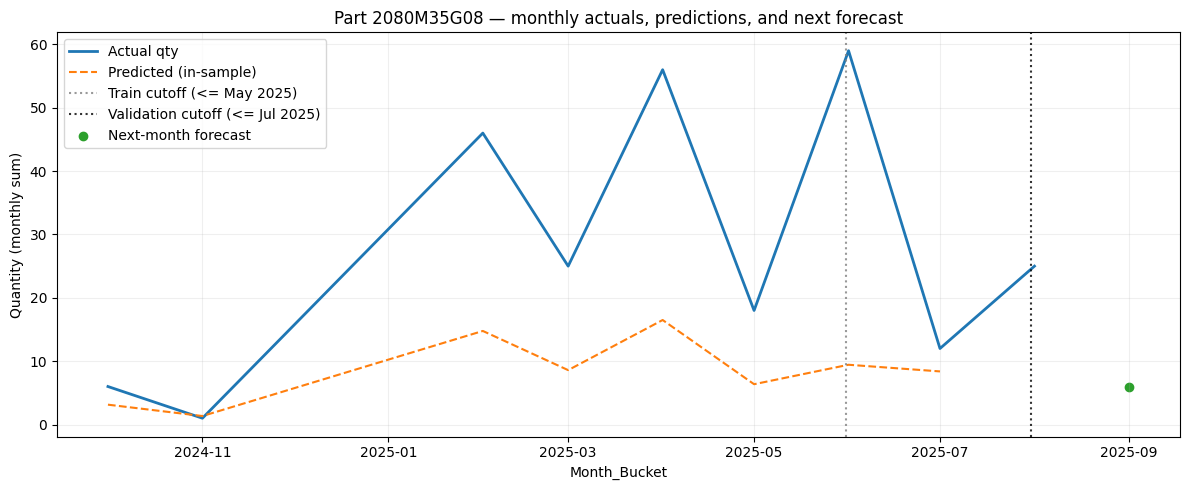

(5.8853373527526855, Timestamp('2025-09-01 00:00:00'))

In [ ]:
plot_part_history_and_forecast('2080M35G08') #Alt Group 1029

# Hex Tech DATA


{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 1.1363810300827026, 'RMSE': 2.2325945609678732, 'n': 9}, 'valid': {'MAE': 5.370192050933838, 'RMSE': 5.423385365773264, 'n': 2}}}


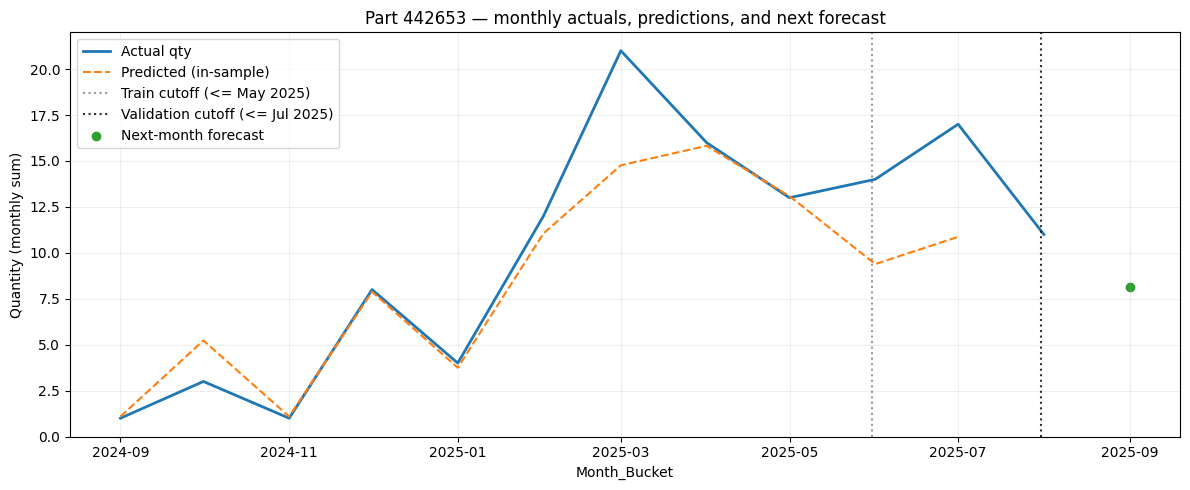

(8.147639274597168, Timestamp('2025-09-01 00:00:00'))

In [42]:
plot_part_history_and_forecast('442653')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 45.144744873046875, 'RMSE': 53.693997896936764, 'n': 9}, 'valid': {'MAE': 282.98150634765625, 'RMSE': 282.98150337080335, 'n': 1}}}


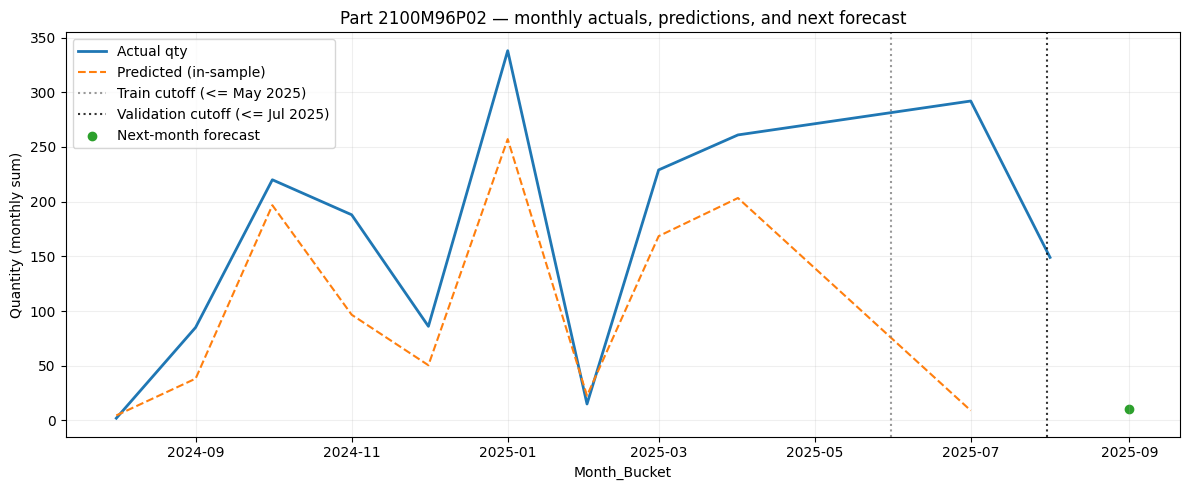

(10.76816463470459, Timestamp('2025-09-01 00:00:00'))

In [ ]:
plot_part_history_and_forecast('2100M96P02')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 10.238981246948242, 'RMSE': 16.71659686047681, 'n': 7}, 'valid': {'MAE': 44.11714172363281, 'RMSE': 51.29948306650492, 'n': 2}}}


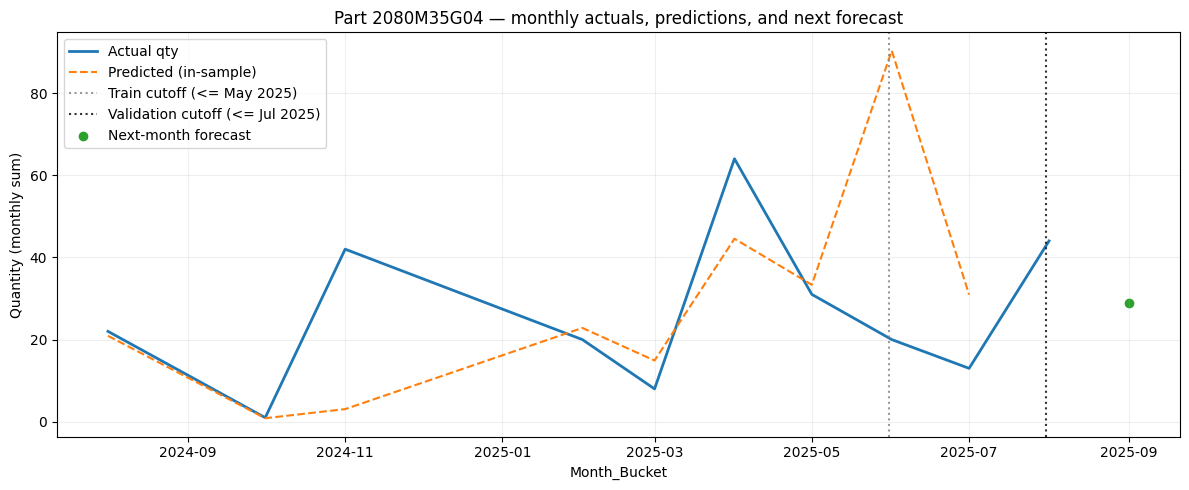

(28.843875885009766, Timestamp('2025-09-01 00:00:00'))

In [ ]:
plot_part_history_and_forecast('2080M35G04')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 0.6384596824645996, 'RMSE': 0.8328492347960648, 'n': 8}, 'valid': {'MAE': 5.056817054748535, 'RMSE': 6.817938077789234, 'n': 2}}}


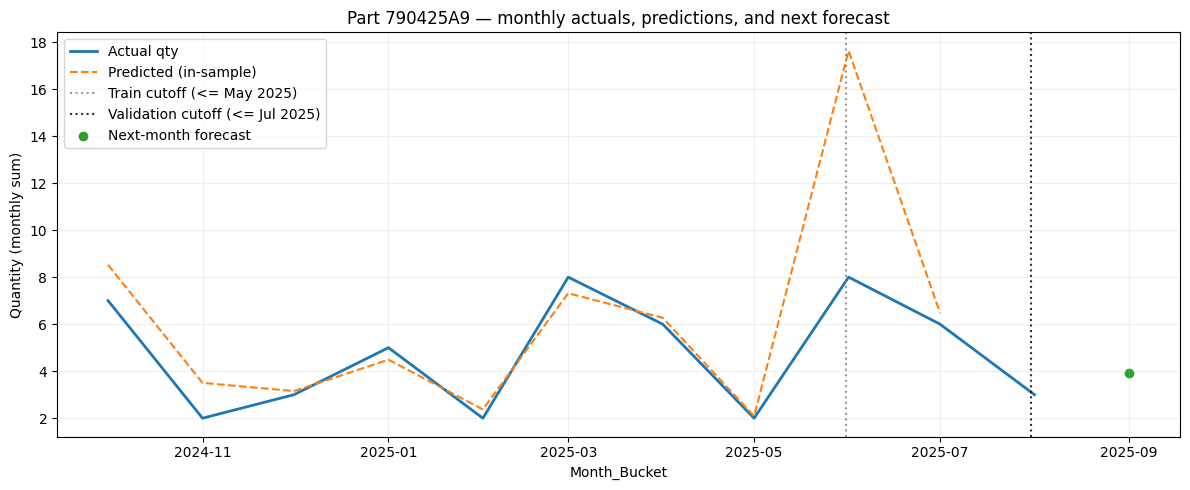

(3.9145090579986572, Timestamp('2025-09-01 00:00:00'))

In [ ]:
plot_part_history_and_forecast('790425A9')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 16.9976806640625, 'RMSE': 22.16891621047961, 'n': 6}, 'valid': {'MAE': 26.59039306640625, 'RMSE': 35.14077610850126, 'n': 2}}}


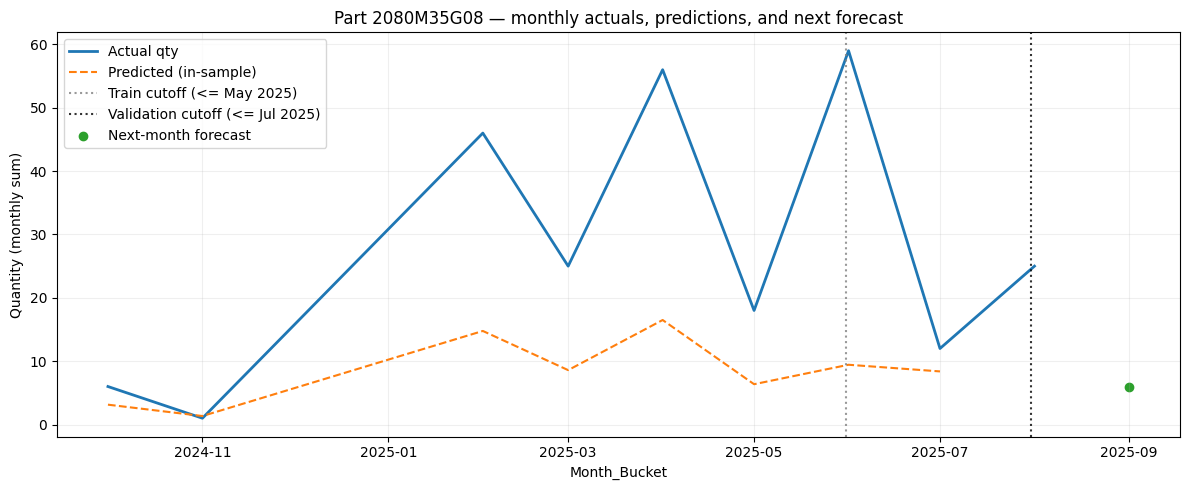

(5.8853373527526855, Timestamp('2025-09-01 00:00:00'))

In [46]:
plot_part_history_and_forecast('2080M35G08')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 1.930572509765625, 'RMSE': 2.4458350455057714, 'n': 10}, 'valid': {'MAE': 3.8424267768859863, 'RMSE': 4.324413484704525, 'n': 2}}}


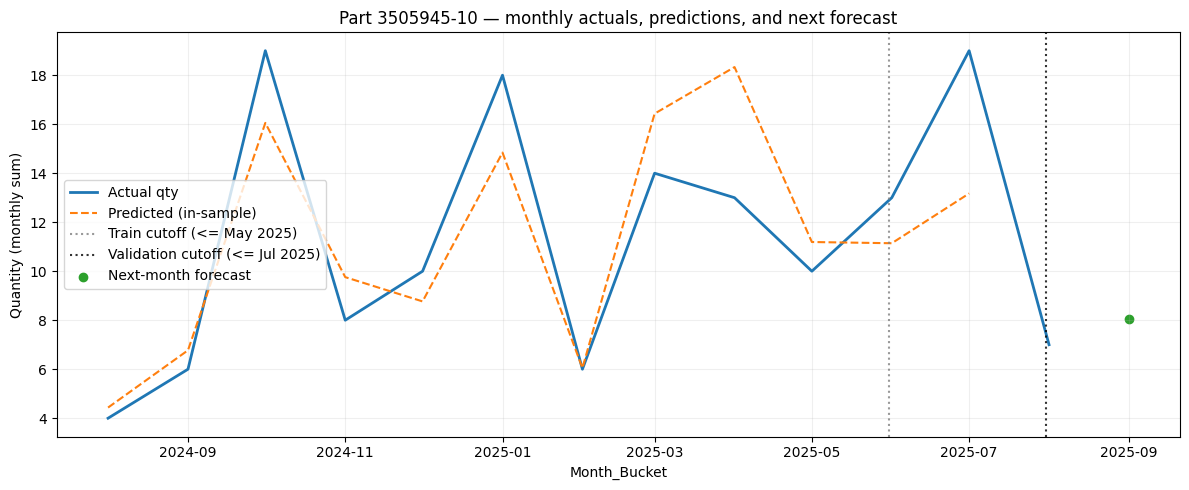

(8.057037353515625, Timestamp('2025-09-01 00:00:00'))

In [47]:
plot_part_history_and_forecast('3505945-10')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 0.9339984059333801, 'RMSE': 1.2043828952690867, 'n': 8}, 'valid': {'MAE': 0.684518575668335, 'RMSE': 0.6845185699716496, 'n': 1}}}


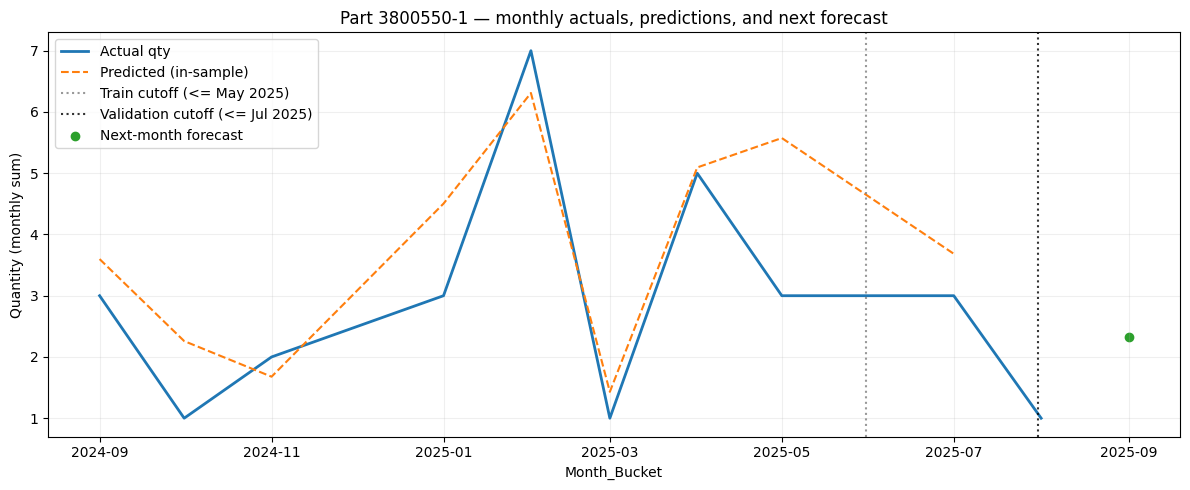

(2.3232262134552, Timestamp('2025-09-01 00:00:00'))

In [48]:
plot_part_history_and_forecast('3800550-1')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 2.6086599826812744, 'RMSE': 3.99130340760265, 'n': 6}, 'valid': {'MAE': 2.872101306915283, 'RMSE': 3.3859168206513326, 'n': 2}}}


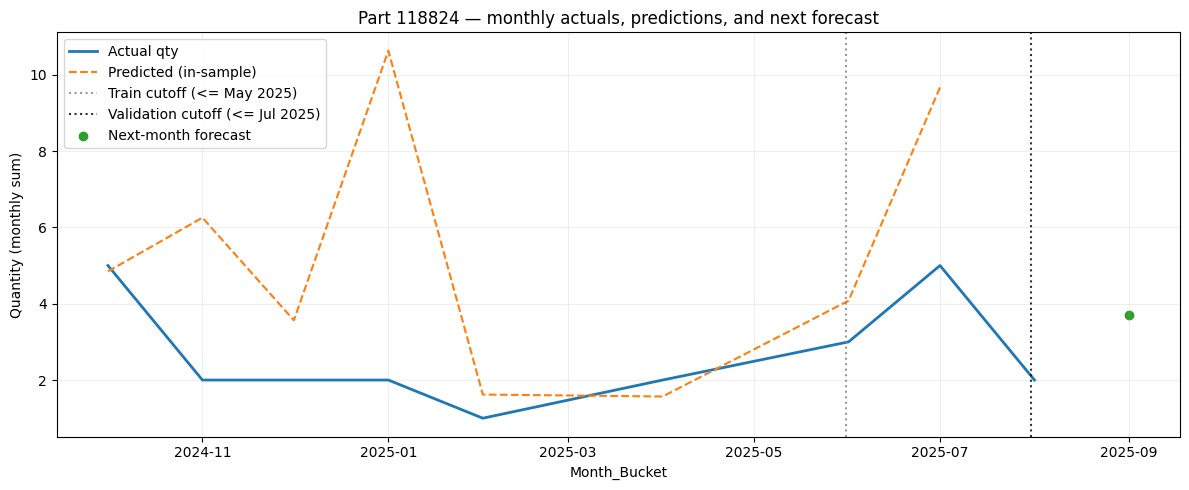

(3.7071142196655273, Timestamp('2025-09-01 00:00:00'))

In [49]:
plot_part_history_and_forecast('118824')

{'cutoffs': {'train': '2025-05-31', 'valid': '2025-07-31'}, 'metrics': {'train': {'MAE': 9.25572681427002, 'RMSE': 12.522951341546225, 'n': 10}, 'valid': {'MAE': 3.4283347129821777, 'RMSE': 3.428334727518048, 'n': 1}}}


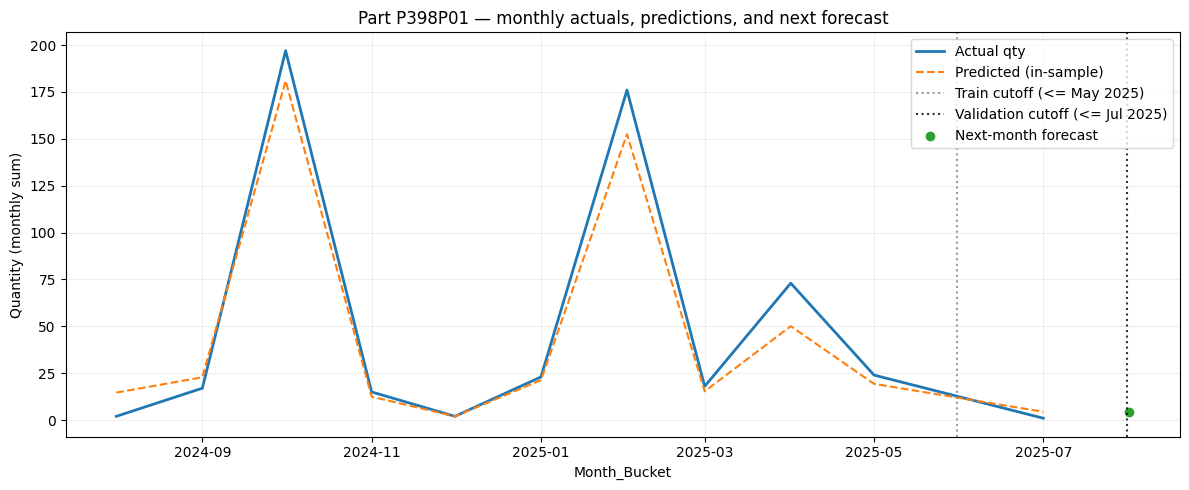

(4.207729816436768, Timestamp('2025-08-01 00:00:00'))

In [50]:
plot_part_history_and_forecast('P398P01')